In [ ]:
import os
import json
import pickle as pkl
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin
from rasterio.plot import show
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def get_key_slice(d, start, end):
    return list(d.keys())[start:end]

def get_mosaics_by_indices(indices, gdf, bands, date_slice_start, date_slice_end):
    data_files = []
    for idx in indices:
        tile_data_files = gdf.at[idx, 'date_files_mapping']
        for query_date in get_key_slice(tile_data_files, date_slice_start, date_slice_end):
            data_file = tile_data_files[query_date][0]
            with rioxarray.open_rasterio(data_file) as ds:
                date_str = ds.time
            date = np.datetime64(date_str, 'ns')
            data_files.append({'idx': idx, 'data_file': data_file, 'date': date})

    # Get unique dates within the date range
    dates = sorted(set(f['date'] for f in data_files))
    mosaics = []

    for date in dates:
        files_for_date = [f for f in data_files if f['date'] == date]
        rasterio_datasets = []

        # Open each file with nodata set to -1, and keep datasets open
        for f in files_for_date:
            src = rasterio.open(f['data_file'])
            profile = src.profile.copy()
            profile.update(nodata=-1)  # Set nodata to -1 in the profile

            # Copy the data into a memory file with updated nodata
            memfile = MemoryFile()
            temp_dataset = memfile.open(**profile)
            temp_dataset.write(src.read())
            rasterio_datasets.append(temp_dataset)  # Append the open dataset to the list

        # Merge the datasets while they are still open
        mosaic_array, out_trans = merge(rasterio_datasets, nodata=-1)

        # Metadata updates
        out_meta = rasterio_datasets[0].meta.copy()
        out_meta.update({
            "height": mosaic_array.shape[1],
            "width": mosaic_array.shape[2],
            "transform": out_trans,
            "nodata": -1  # Ensure no-data is specified in metadata
        })

        # Generate coordinate arrays
        transform = out_trans
        height, width = mosaic_array.shape[1], mosaic_array.shape[2]
        x_coords = np.arange(width) * transform.a + transform.c + transform.a / 2
        y_coords = np.arange(height) * transform.e + transform.f + transform.e / 2

        # Create xarray DataArray from the mosaic
        mosaic_da = xr.DataArray(
            mosaic_array,
            dims=('band', 'y', 'x'),
            coords={'band': bands, 'y': y_coords, 'x': x_coords},
            attrs={'transform': transform, 'crs': out_meta['crs']}
        )

        # Add time coordinate
        mosaic_da = mosaic_da.expand_dims({'time': [date]})
        mosaics.append(mosaic_da)

        # Properly close each MemoryFile after merge
        for dataset in rasterio_datasets:
            dataset.close()

    # Stack the mosaics over time
    stacked_mosaics = xr.concat(mosaics, dim='time')

    return stacked_mosaics

# NOT IN USE
def save_as_netcdf_with_time(stacked_mosaics, output_path, bands):
    # Convert the CRS to a string for NetCDF compatibility
    stacked_mosaics.attrs['crs'] = str(stacked_mosaics.attrs['crs'])
    # Set any desired attributes here if needed
    stacked_mosaics.attrs['time'] = str(stacked_mosaics.coords['time'].values[0])
    stacked_mosaics.attrs['bands'] = ",".join(bands)  # Add band names as metadata

    # Save as a NetCDF file
    stacked_mosaics.to_netcdf(output_path)

# Load data
gdf = gpd.read_file("../data/tiles_with_dates.geojson")
gdf['date_files_mapping'] = gdf['date_files_mapping'].apply(lambda x: json.loads(x))

county_boundary = gpd.read_file("../data/county_boundary.shp")

In [ ]:
# Define bands
bands = ['B02', 'B03', 'B04', 'B08']

# Define the target CRS and resolution (assuming 10x10 meter resolution based on Sentinel-2)
target_crs = "EPSG:32617"
x_res, y_res = 10, 10  # 10-meter resolution

# Create a list of lists, each containing a range of integers for each batch
batch_size = 100
total_indices = len(gdf)
batches = [list(range(i, min(i + batch_size, total_indices))) for i in range(0, total_indices, batch_size)]  

# Directory to save each batch as a .tif file
batch_sentinel2_rast_dir = "../data/batch_sentinel2_rasts"
os.makedirs(batch_sentinel2_rast_dir, exist_ok=True)

# Save each batch as a .tif after reprojecting to the target grid
for i, batch in enumerate(batches):
    output_filename = os.path.join(batch_sentinel2_rast_dir, f"sentinel2_batch_{i}.tif")
    if os.path.exists(output_filename):
        continue

    print(f"Loading batch {i + 1}/{len(batches)}")
    net_cdf_batch_by_idx = get_mosaics_by_indices(batch, gdf, bands, 0, 1)
    rgb_rast_batch = net_cdf_batch_by_idx.sel(band=['B04', 'B03', 'B02']).isel(time=0)
    
    # Calculate the transform for this tile based on bounds
    bounds = gdf.iloc[batch].total_bounds  # or specific bounds for each tile
    transform = from_origin(bounds[0], bounds[3], x_res, y_res)  # left, top, x_res, y_res
    
    # Define metadata for saving as a .tif
    metadata = {
        'driver': 'GTiff',
        'height': rgb_rast_batch.shape[1],
        'width': rgb_rast_batch.shape[2],
        'count': 3,  # RGB bands
        'dtype': 'float32',
        'crs': net_cdf_batch_by_idx.attrs['crs'],
        'transform': transform,
        'nodata': -1
    }
    
    # Save the batch RGB raster as .tif with the unique transform
    with rasterio.open(output_filename, 'w', **metadata) as dst:
        for band in range(3):
            dst.write(rgb_rast_batch.values[band], band + 1)
    print(f"Saved batch {i + 1}/{len(batches)} to {output_filename}")
    
    # Close the dataset to free up memory
    net_cdf_batch_by_idx.close()

In [3]:
# Merging all reprojected batch .tif files into a single raster
final_output_path = "../data/sentinel2_mosaic_merged.tif"
if not os.path.exists(final_output_path):
    print("Merging all batch .tif files into a single raster...")
    tif_files = [os.path.join(batch_sentinel2_rast_dir, f) 
                 for f in os.listdir(batch_sentinel2_rast_dir) if f.endswith(".tif")]
    datasets = [rasterio.open(tif) for tif in tif_files]
    
    # Define the bounds based on the county's total bounds
    county_bounds = list(gdf.total_bounds)
    
    # Merge datasets with explicit bounds
    mosaic, out_trans = merge(datasets, nodata=-1, bounds=county_bounds)

    # Define metadata for the final merged file
    out_meta = datasets[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": 3  # RGB bands
    })
    with rasterio.open(final_output_path, "w", **out_meta) as dest:
        for band in range(3):
            dest.write(mosaic[band], band + 1)
    print(f"Final merged raster saved to {final_output_path}")

    # Close all datasets
    for dataset in datasets:
        dataset.close()
else:
    print(f"Final merged raster already exists at {final_output_path}")

Merging all batch .tif files into a single raster...
Final merged raster saved to ../data/sentinel2_mosaic_merged.tif


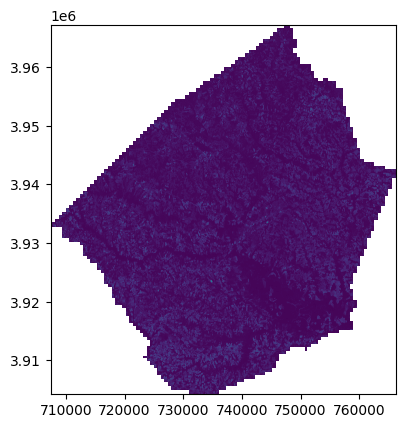

In [ ]:
with rasterio.open(final_output_path) as src:
    show(src)

In [6]:
for i, tif in enumerate(tif_files):
    with rasterio.open(tif) as src:
        print(f"Dataset {i+1} CRS: {src.crs}")
        print(f"Dataset {i+1} Transform: {src.transform}")
        print(f"Dataset {i+1} Bounds: {src.bounds}")
        print(f"Dataset {i+1} Shape: {src.shape}")

Dataset 1 CRS: EPSG:32617
Dataset 1 Transform: | 10.00, 0.00, 707400.00|
| 0.00,-10.00, 3939000.00|
| 0.00, 0.00, 1.00|
Dataset 1 Bounds: BoundingBox(left=707400.0, bottom=3927000.0, right=714000.0, top=3939000.0)
Dataset 1 Shape: (1200, 660)
Dataset 2 CRS: EPSG:32617
Dataset 2 Transform: | 10.00, 0.00, 713400.00|
| 0.00,-10.00, 3941400.00|
| 0.00, 0.00, 1.00|
Dataset 2 Bounds: BoundingBox(left=713400.0, bottom=3924600.0, right=716400.0, top=3941400.0)
Dataset 2 Shape: (1680, 300)
Dataset 3 CRS: EPSG:32617
Dataset 3 Transform: | 10.00, 0.00, 725400.00|
| 0.00,-10.00, 3951600.00|
| 0.00, 0.00, 1.00|
Dataset 3 Bounds: BoundingBox(left=725400.0, bottom=3906600.0, right=726600.0, top=3951600.0)
Dataset 3 Shape: (4500, 120)
Dataset 4 CRS: EPSG:32617
Dataset 4 Transform: | 10.00, 0.00, 726000.00|
| 0.00,-10.00, 3952200.00|
| 0.00, 0.00, 1.00|
Dataset 4 Bounds: BoundingBox(left=726000.0, bottom=3906000.0, right=727200.0, top=3952200.0)
Dataset 4 Shape: (4620, 120)
Dataset 5 CRS: EPSG:32617
Da

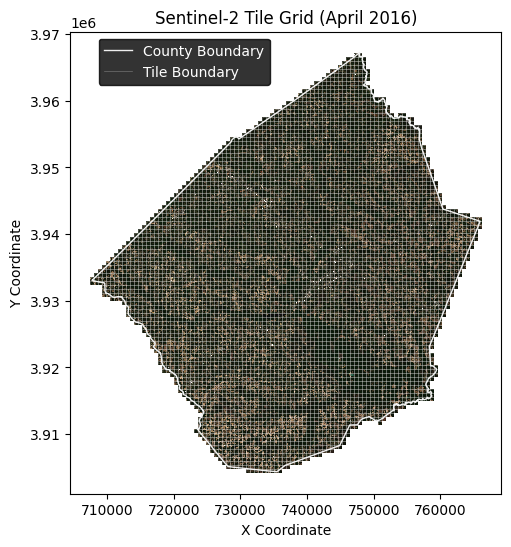

In [12]:
# Load the merged raster
with rasterio.open(final_output_path) as src:
    # Read RGB bands (assuming bands 1, 2, and 3 are in the order R, G, B)
    rgb_array = src.read([1, 2, 3]).astype("float32")

    # Set x and y extent using the transform
    x_min, y_min = src.bounds.left, src.bounds.bottom
    x_max, y_max = src.bounds.right, src.bounds.top

# Step 1: Normalize the RGB array
rgb_array_normalized = rgb_array / rgb_array.max()  # Normalize data to [0, 1]

# Step 2: Mask areas where values are NaN or below zero (for brightness/contrast adjustments)
rgb_array_mask = np.isnan(rgb_array_normalized) | (rgb_array_normalized < 0)

# Step 3: Enhance brightness and contrast only on valid data
brightness_factor = 1.7  # Adjust brightness (values > 1 increase brightness)
contrast_factor = 2.1    # Adjust contrast (values > 1 increase contrast)
rgb_array_brightened = np.clip(rgb_array_normalized * brightness_factor * contrast_factor, 0, 1)

# Step 4: Apply the mask to set these areas to white (1, 1, 1)
rgb_array_brightened[rgb_array_mask] = 1  # Set NaN or negative areas to white

# Step 5: Plot the RGB image
fig, ax = plt.subplots(figsize=(6, 6))

# Display the RGB image with spatial extents (no buffer applied to the data extent)
img = ax.imshow(
    rgb_array_brightened.transpose(1, 2, 0),
    extent=[x_min, x_max, y_min, y_max],
    interpolation="nearest"
)

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='#efefef', linewidth=1.)
gdf.boundary.plot(ax=ax, edgecolor='#ffffff', linewidth=0.5, alpha=0.3)

# Create custom legend elements for County Boundary and Tile Boundary
legend_elements = [
    Line2D([0], [0], color='#efefef', lw=1., label='County Boundary'),
    Line2D([0], [0], color='#ffffff', lw=0.5, label='Tile Boundary', alpha=0.3),
]

# Add the legend for County Boundary and Tile Boundary with a black background and white text
legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.05, 1), frameon=True)
legend.get_frame().set_facecolor('black')  # Set legend background color to black
legend.get_frame().set_edgecolor('black')  # Set legend border color to black

# Set the text color of the legend to white
for text in legend.get_texts():
    text.set_color("white")
    
# Title and labels
plt.title(f'Sentinel-2 Tile Grid (April 2016)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Adjust xlim and ylim to add padding around the raster
x_padding = (x_max - x_min) * 0.05  # 5% padding on x-axis
y_padding = (y_max - y_min) * 0.05  # 5% padding on y-axis
ax.set_xlim(x_min - x_padding, x_max + x_padding)
ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.show()